In [1]:
# Instalar las librerías necesarias
!pip install rasterio numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 91.7 MB/s eta 0:00:00


In [2]:
# Importar librerías
import ee
import geemap
import geopandas as gpd
import os
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.merge import merge

# Autenticación e inicialización de GEE
ee.Authenticate()
ee.Initialize(project="festive-bazaar-282413")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carpeta donde se encuentra el shapefile (y ahora el mosaico)
shapefile_path = "/content/drive/MyDrive/ALTURA_DOSEL_CLASE3/cuadricula.shp"
output_folder = os.path.dirname(shapefile_path)

# Ruta del mosaico generado
mosaic_path = os.path.join(output_folder, "Mosaico_Altura_Dosel.tif")

In [ ]:
# Definir el mapa interactivo
Map = geemap.Map()
Map.add("basemap_selector")

# Cargar el mapa global de altura de dosel
canopy_ht = ee.ImageCollection("projects/meta-forest-monitoring-okw37/assets/CanopyHeight").mosaic()

# Definir parámetros de visualización
viz = {"min": 0.3, "max": 14.7, "palette": ["e9edcb", "53f364", "27b522", "115602"]}

# Agregar la capa al mapa
Map.addLayer(canopy_ht, viz, "Altura dosel 1m")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:

# Cargar el shapefile
zona_gdf = gpd.read_file(shapefile_path)

# Crear una nueva columna con nombres de las cuadrículas
zona_gdf["Nombre"] = ["Cuadro_" + str(i) for i in zona_gdf["id"]]

# Convertir el CRS a EPSG:4326 para que sea compatible con GEE
zona_gdf_geo = zona_gdf.to_crs(epsg=4326)

# Convertir el GeoDataFrame en una FeatureCollection de GEE
ee_shp_gdp = ee.FeatureCollection(zona_gdf_geo.__geo_interface__)

# Extraer la lista de nombres de las cuadrículas
lista_name = ee_shp_gdp.reduceColumns(ee.Reducer.toList(), ["Nombre"]).get("list").getInfo()


In [ ]:
# Obtener la carpeta del shapefile para guardar las imágenes
output_folder = os.path.dirname(shapefile_path)

# Descargar cada imagen recortada por cuadrícula
for name in lista_name:
    Cuadro = ee_shp_gdp.filterMetadata('Nombre', 'equals', name)
    geometria = Cuadro.geometry()
    canopy_ht_clip = canopy_ht.clip(geometria)

    # Ruta del archivo de salida
    output_path = os.path.join(output_folder, f"Altura_dosel_1m_{name}.tif")

    # Exportar la imagen
    geemap.ee_export_image(
        canopy_ht_clip,
        filename=output_path,
        region=geometria,
        scale=1,
        file_per_band=False
    )
    print(f'Imagen {name} descargada en {output_folder}')


Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/ALTURA_DOSEL_CLASE3/Altura_dosel_1m_Cuadro_1.0.tif
Imagen Cuadro_1.0 descargada en /content/drive/MyDrive/ALTURA_DOSEL_CLASE3
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/ALTURA_DOSEL_CLASE3/Altura_dosel_1m_Cuadro_2.0.tif
Imagen Cuadro_2.0 descargada en /content/drive/MyDrive/ALTURA_DOSEL_CLASE3
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/ALTURA_DOSEL_CLASE3/Altura_dosel_1m_Cuadro_3.0.tif
Imagen Cuadro_3.0 descargada en /content/drive/MyDrive/ALTURA_DOSEL_CLASE3
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/ALTURA_DOSEL_CLASE3/Altura_dosel_1m_Cuadro_4.0.tif
Imagen Cuadro_4.0 descargada en /content/drive/MyDrive/ALTURA_DOSEL_CLASE3
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/ALTURA_DOSEL_CLASE3/Altura_dosel_1m_Cuadro_5.0.tif
Imagen Cuadro_5.0 descargada en /content/drive/MyDrive/ALTUR

In [ ]:
# Buscar todas las imágenes descargadas en la carpeta del shapefile
tif_files = glob.glob(os.path.join(output_folder, "Altura_dosel_1m_*.tif"))

# Abrir y combinar las imágenes en un mosaico
src_files_to_mosaic = [rasterio.open(fp) for fp in tif_files]
mosaic, out_trans = merge(src_files_to_mosaic)

# Ruta del mosaico final
mosaic_output_path = os.path.join(output_folder, "Mosaico_Altura_Dosel.tif")
mosaic_meta = src_files_to_mosaic[0].meta.copy()

# Actualizar la metadata con la nueva dimensión y transformación
mosaic_meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans
})

# Guardar el mosaico en un archivo TIFF
with rasterio.open(mosaic_output_path, "w", **mosaic_meta) as dest:
    dest.write(mosaic)

print(f"Mosaico final guardado en {mosaic_output_path}")

# Eliminar imágenes individuales después de crear el mosaico
for tif_file in tif_files:
    os.remove(tif_file)

print("Archivos individuales eliminados. Solo se conserva el mosaico final.")


Mosaico final guardado en /content/drive/MyDrive/ALTURA_DOSEL_CLASE3/Mosaico_Altura_Dosel.tif
Archivos individuales eliminados. Solo se conserva el mosaico final.


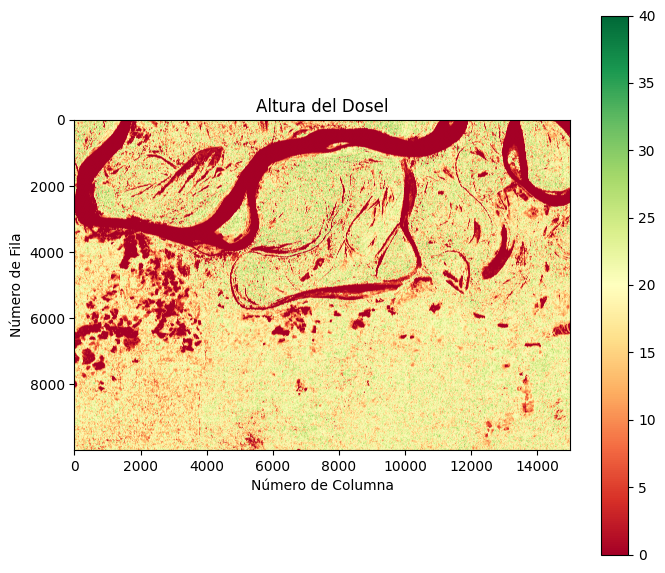

In [ ]:
# Abrir el mosaico de altura del dosel
Altura_dosel = rasterio.open("/content/Mosaico_Altura_Dosel.tif")

# Leer los valores del raster en un array numpy
Altura = Altura_dosel.read(1)

# Graficar el raster original
plt.figure(figsize=(8, 7))
plt.imshow(Altura, cmap='RdYlGn')  # Opciones: jet, Spectral, viridis
plt.colorbar()
plt.title("Altura del Dosel")
plt.xlabel("Número de Columna")
plt.ylabel("Número de Fila")
plt.show()

In [ ]:
# Estadísticas del raster
print("Valor mínimo Altura:", round(Altura.min(), 3))
print("Valor máximo Altura:", round(Altura.max(), 3))
print("Valor promedio Altura:", round(Altura.mean(), 3))
print("Valor desviación estándar Altura:", round(Altura.std(), 3))
print("Valor varianza Altura:", round(Altura.var(), 3))
print("Dimensiones Altura:", Altura.shape)
print("Tipo de dato Altura:", Altura.dtype)
print("Total de píxeles Altura:", Altura.size)

# Definir clases de altura
Clasifi = [-np.inf, 1, 5, 10, 15, 20, np.inf]

# Aplicar la clasificación
altura_Class = np.digitize(Altura, Clasifi)

# Graficar la clasificación
plt.figure(figsize=(8, 7))
plt.imshow(altura_Class, cmap='RdYlGn')
plt.colorbar()
plt.title("Clasificación de Altura del Dosel")
plt.xlabel("Número de Columna")
plt.ylabel("Número de Fila")

# Define output_folder here, or move this entire cell after cell 11 or 12
shapefile_path = "/content/poli2.shp"  # Assuming shapefile_path is defined somewhere
output_folder = os.path.dirname(shapefile_path)

plt.savefig(os.path.join(output_folder, "Clasificacion_Altura.jpg"), dpi=300, bbox_inches='tight')
plt.show()

# Convertir la clasificación a tipo entero
altura_Class = altura_Class.astype(np.uint8)

# Obtener los metadatos del raster original y actualizarlos
param_clas = Altura_dosel.meta
param_clas.update(count=1, nodata=None, dtype='uint8')

# Ruta del archivo de salida
name_altura_clas = os.path.join(output_folder, "Mosaico_Altura_Dosel_Class.tif")

# Exportar el raster clasificado
with rasterio.open(name_altura_clas, 'w', **param_clas) as DATOS:
    DATOS.write_band(1, altura_Class)

print(f"Clasificación de altura guardada en {name_altura_clas}")

NameError: name 'Altura' is not defined